#APTAS

In [5]:
import math
from typing import List, Tuple

try:
  import pulp
except ImportError:
  __import__('subprocess').check_call([__import__('sys').executable, '-m', 'pip', 'install', 'pulp'], stdout=None,
                                      stderr=None);
  import pulp
from collections import Counter
from itertools import combinations
import sys
import itertools

sys.setrecursionlimit(20000)

# Item indices
WIDTH = 0
HEIGHT = 1


class APTAS:
  aleph = None

  def __init__(self, items: List[Tuple[float, float]], epsilon: float):
    self.items = items
    if epsilon > 0.1:
      self.epsilon = epsilon
    else:
      self.epsilon = 0.1

  # part a
  def decomposition(self):
    """Find optimal f and group items into A_i sets.
   Decomposition:

(a.1) Guess the integer ff (1≤f≤t:=1/ε) and for i∈I ⁣ ⁣Ni∈IN remove all the items
   with height in (εf+it,εf+it−1).
(a.2) Let AiAi​ be the set of the items with heights in [εf+it−1,εf+(i−1)t] for each
   i∈I ⁣ ⁣Ni∈IN. Form the shelves in the final solution by considering separately each set Ai​.
   """
    t = math.ceil(1 / self.epsilon)
    best_profit = -1
    opt_f = None
    opt_A = []
    # print(t, self.epsilon)
    # guess f by bruteforcing all over the place
    for f in range(1, t + 1):
      A = [[] for _ in range(t)]
      for item in self.items:
        h = item[HEIGHT]

        for i in range(t):
          lower = self.epsilon ** (f + i * t - 1)
          upper = self.epsilon ** (f + (i - 1) * t) if not i == 0 else 1
          # print(lower, upper)
          if lower <= h <= upper: # and not self.epsilon ** (f + i * t) < h < upper:
            A[i].append(item)
            break

      profits = [sum(w * h for w, h in group) for group in A]

      min_idx = profits.index(min(profits))  # rm the least profittable bucket

      remaining_groups = [g for idx, g in enumerate(A) if idx != min_idx]
      current_profit = sum(w * h for g in remaining_groups for w, h in g)

      # print(opt_f)
      if current_profit > best_profit:
        best_profit = current_profit
        opt_f = f
        opt_A = remaining_groups

    return opt_f, opt_A

  # part b
  def subdivide_and_melt(self, f: int, A: List[List[Tuple[float, float]]]):
    """Divide items into wide and thin; return thin items separately.
   Item Subdivision and Vertical Melting: For each set Ai​, i∈I ⁣ ⁣Ni∈IN:
(b.1) Separate wide items (having width at least εtεt) from thin items (having width smaller than εtεt).
(b.2) Allow thin items to be cut vertically.
   """
    t = math.ceil(1 / self.epsilon)
    wide_groups = []
    thin_items_groups = []
    for A_i in A:
      wide_items = [item for item in A_i if item[WIDTH] >= self.epsilon ** t]
      thin_items = [item for item in A_i if item[WIDTH] < self.epsilon ** t]
      wide_groups.append(wide_items)
      thin_items_groups.append(thin_items)
    return wide_groups, thin_items_groups

  # part c
  def nfdh_pack(self, items: List[Tuple[float, float]], H: float = 1.0) -> bool:
    """Check if NFDH can pack all items within height H."""
    sorted_items = sorted(items, key=lambda x: -x[1])  # Sort by decreasing height
    shelves = []
    current_shelf_items = []
    current_shelf_width = 0
    total_height = 0

    for item in sorted_items:
      if current_shelf_width + item[0] > 1:  # exceeding shelve's width
        if current_shelf_items:
          shelf_height = max(item[1] for item in current_shelf_items)
          if total_height + shelf_height > H:  # false if height exceeds H
            return False
          # otherwise
          shelves.append(current_shelf_items)
          total_height += shelf_height
        current_shelf_items = [item]
        current_shelf_width = item[0]
      else:
        current_shelf_items.append(item)
        current_shelf_width += item[0]

    if current_shelf_items:
      shelf_height = max(item[1] for item in current_shelf_items)
      if total_height + shelf_height > H:
        return False
      shelves.append(current_shelf_items)
    return True

  def low_shelves(self, wide_groups: List[List[Tuple[float, float]]],
                  thin_items_groups: List[List[Tuple[float, float]]], f: int):
    t = math.ceil(1 / self.epsilon)
    pi_list = []
    for i in range(1, len(wide_groups)):
      wide = wide_groups[i]
      thin = thin_items_groups[i]
      if not wide and not thin:
        pi_list.append({})
        continue

      # round heights to format (org_w, org_h, rounded_up_h, rounded_down_h)
      heights_info = [
        (w, h, math.ceil(h / self.epsilon ** (f + i * t)) * self.epsilon ** (f + i * t),
         math.floor(h / self.epsilon ** (f + i * t)) * self.epsilon ** (f + i * t))
        for w, h in wide
      ]

      hc_list = [hc for _, _, hc, _ in heights_info]
      counts_map = Counter(hc_list)
      heights_i = sorted(counts_map.keys(), reverse=True)  # distinct heights at shelf A_i (^h_g_i)
      counts_i = [counts_map[hc] for hc in heights_i]  # number of items at distinct height at shelf A_i (n_g_i)

      def enumerate_m(heights, counts, max_height=1.0):
        g = len(heights)  # number of distinct heights
        current = [0] * g  # current setting (m_1, m_2, ..., m_g_i)

        def dfs(j, remaining_height):
          if j == g:  # base case j == g: setting fully init-ed
            yield tuple(current)
            return

          # max value of m_j satisfies not exceeding number of items at that height and
          # still fits under remaining height budget
          max_mj = min(counts[j], int(remaining_height // heights[j]))
          # loop over all possibile m_j
          for mj in range(max_mj + 1):
            current[j] = mj
            yield from dfs(j + 1, remaining_height - mj * heights[j])
          current[j] = 0

        yield from dfs(0, max_height)

      pi = {}
      for m_vec in enumerate_m(heights_i, counts_i):
        # form the item list based on configuration m_j
        item_list = []
        for idx, m_j in enumerate(m_vec):
          h_j = heights_i[idx]
          count = 0
          for w, _, hc, _ in heights_info:
            if hc == h_j and count < m_j:
              item_list.append((w, hc))
              count += 1
        total_height = sum(m_j * heights_i[idx] for idx, m_j in enumerate(m_vec))  # H

        if self.nfdh_pack(item_list, total_height):
          # case 1: nfdh fits, compute profit directly, no profit loss
          profit = sum(w * h for w, h in item_list)
          pi[total_height] = max(pi.get(total_height, 0), profit)
        else:
          # case 2: nfdg doesn't fit, proceed with preprocessing, grouping, and MIP
          # (c.2.1) Preprocess wide items for each height class
          preprocessed_items = []  # R_ij
          H_limit = total_height
          limit = H_limit / (self.epsilon ** (f + (i + 1) * t - 1))

          for h_j in heights_i:
            S_ij = [item for item in heights_info if item[2] == h_j]
            T_ijk = {}
            for item in S_ij:
              w = item[0]
              k = math.ceil(w / self.epsilon ** (t + 1))
              if k not in T_ijk:
                T_ijk[k] = []
              T_ijk[k].append(item)
            for k in T_ijk:
              lower = 1 / self.epsilon
              upper = 1 / self.epsilon ** (t + 1)
              if k >= lower and k <= upper:
                T_ijk[k].sort(key=lambda x: x[0])
                selected = T_ijk[k][:int(limit)]
                preprocessed_items.extend(selected)

          # (c.2.2) linear Grouping
          # group by heights
          height_groups = {}
          for item in preprocessed_items:
            hc = item[2]
            if hc not in height_groups:
              height_groups[hc] = []
            height_groups[hc].append(item)

          grouped_items = []  # format (min_width, height, hc, hf)
          threshold = 8 / (self.epsilon ** (5 * t))
          for hc, items in height_groups.items():
            r_ij = len(items)
            if r_ij < threshold:
              grouped_items.extend([(w, w, h, hc) for w, h, hc, _ in items])
            else:
              p_i = math.floor(1 / (4 * (self.epsilon ** (f + (i - 1) * t))))
              if p_i < 1:
                grouped_items.extend((w, h, hc, hf) for w, h, hc, hf in items)
                continue

              items.sort(key=lambda x: x[WIDTH], reverse=True)
              for idx, (w, h, _, _) in enumerate(items):
                group_idx = idx // p_i
                first_in_group = group_idx * p_i
                bar_w = items[first_in_group][0]
                under_w = items[idx + p_i][0] if idx + p_i < r_j else 0
                grouped_items.append((bar_w, under_w, h, hc))

          # prepare wide item types: (width, height, count)
          wide_dict = Counter([(item[WIDTH], item[3]) for item in grouped_items])
          wide_types = [(w, hf, n) for (w, hf), n in wide_dict.items()]

          # prepare thin item types: (total_width, height)
          thin_dict = {}
          for w, h in thin:
            thin_dict[h] = thin_dict.get(h, 0) + w
          thin_types = [(w, h) for h, w in thin_dict.items()]

          # enumerate shelf configurations
          shelf_configs = self.enumerate_shelf_configs(wide_types)

          # (c.2.3) solve MIlP for this H
          try:
            profit = self.solve_shelf_mip(shelf_configs, wide_types, thin_types, total_height)
            pi[total_height] = max(pi.get(total_height, 0), profit)
          except RuntimeError:
            continue
      pi_list.append(pi)
    return pi_list

  def enumerate_shelf_configs(self, wide_types: List[Tuple[float, float, int]]) -> List[dict]:
    configs = []
    heights = set(h for _, h, _ in wide_types)
    for height in heights:
      for r in range(1, len(wide_types) + 1):
        for subset in combinations(wide_types, r):
          total_width = sum(w for w, h, _ in subset if h <= height)
          if total_width <= 1:
            wide_counts = {}
            for idx, (w, h, _) in enumerate(wide_types):
              count_in_subset = sum(1 for item in subset if item[0] == w and item[1] == h)
              if count_in_subset > 0:
                wide_counts[idx] = count_in_subset
            config = {
              'height': height,
              'wide_counts': wide_counts,
              'width_used': total_width,
              'profit': sum(w * h for w, h, _ in subset if h <= height)
            }
            configs.append(config)
    return configs

  def solve_shelf_mip(self, shelf_configs: List[dict], wide_types: List[Tuple[float, float, int]],
                      thin_types: List[Tuple[float, float]], H: float) -> float:
    prob = pulp.LpProblem("ShelfPacking", pulp.LpMaximize)

    # Variables
    x = {idx: pulp.LpVariable(f"x_{idx}", lowBound=0, cat="Integer") for idx in range(len(shelf_configs))}
    z = {j: pulp.LpVariable(f"z_{j}", lowBound=0, upBound=thin_types[j][0]) for j in range(len(thin_types))}

    # Objective: Maximize profit
    prob += (
            pulp.lpSum(shelf_configs[idx]['profit'] * x[idx] for idx in range(len(shelf_configs))) +
            pulp.lpSum(thin_types[j][1] * z[j] for j in range(len(thin_types)))
    )

    # Constraint: Total height limit
    prob += pulp.lpSum(shelf_configs[idx]['height'] * x[idx] for idx in range(len(shelf_configs))) <= H

    # Constraint: Wide item availability
    for l, (_, _, n_l) in enumerate(wide_types):
      prob += (
              pulp.lpSum(shelf_configs[idx]['wide_counts'].get(l, 0) * x[idx]
                         for idx in range(len(shelf_configs))) <= n_l
      )

    # Constraint: Thin item fitting
    for j, (w_j, h_j) in enumerate(thin_types):
      prob += (
              pulp.lpSum((1 - shelf_configs[idx]['width_used']) * x[idx]
                         for idx in range(len(shelf_configs))
                         if shelf_configs[idx]['height'] >= h_j) >= z[j]
      )

    # Solve the MIP
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    if pulp.LpStatus[prob.status] != 'Optimal':
      raise RuntimeError("mip could not be solved optimally")
    return pulp.value(prob.objective)

  # part d
  def high_shelves(self, A0_shelf_configs, A0_thin_items, pi_list):
    """
    Processes multi-shelf configurations, packs thin items, and uses remaining height for lower shelves.
    """
    best_profit = 0
    best_config = None

    for config in A0_shelf_configs:
      # prepare shelves for thin item packing
      shelves = config['shelves']
      for shelf in shelves:
        shelf['width_left'] = 1.0 - shelf['width_used']

      # print(shelves)
      # pack thin items into the shelves
      thin_area = fill_thin([shelf.copy() for shelf in shelves], A0_thin_items.copy())

      # Total profit from wide items in the configuration
      wide_profit = config['total_profit']

      # Total height used by the tall shelves
      used_height = config['total_height']
      residual = 1.0 - used_height

      # Use remaining height for lower shelves via multiple-choice knapsack
      mc_profit = multiple_choice_knapsack(pi_list, residual)

      # Total profit for this configuration
      total = wide_profit + thin_area + mc_profit

      if total > best_profit:
        best_profit = total
        best_config = config

    return best_profit, best_config

    # part e
    def fill_thin_with_cuts(self, shelves, thin_items):
      """
      Wrapper for existing fill_thin to track cut items.
      Returns total_area and list of cut items.
      """
      total_area = 0
      cut_items = []
      open_shelves = shelves[:]
      thin = thin_items[:]
      idx_thin = 0

      # Simulate the existing fill_thin logic
      while open_shelves and idx_thin < len(thin):
        w, h = thin[idx_thin]
        shelf = open_shelves[0]
        if w <= shelf['width_left']:
          total_area += w * h
          shelf['width_left'] -= w
          idx_thin += 1
        else:
          # Item is cut vertically
          frac_w = shelf['width_left']
          total_area += frac_w * h
          cut_items.append((w, h))  # Record original item that was cut
          open_shelves.pop(0)  # Shelf is full
        return total_area, cut_items

  def solve(self):
    f, A_groups = self.decomposition()
    # print(f, A_groups)
    if not f:
      print("no f")
      return {'profit': 0.0}
    wide_groups, thin_items_groups = self.subdivide_and_melt(f, A_groups)
    # print(wide_groups, thin_items_groups)
    pi_list = self.low_shelves(wide_groups, thin_items_groups, f)
    A0_shelf_configs = self.enumerate_A0_shelves(wide_groups[0])
    result = self.high_shelves(A0_shelf_configs, thin_items_groups, pi_list)
    return result

  def enumerate_A0_shelves(self, wide_items_A0):
    """
    Enumerates all possible multi-shelf configurations for wide items in A_0.
    Each configuration is a list of shelves where total height <= 1 and shelves are disjoint.
    """
    # Step 1: Generate all possible single-shelf configurations
    single_shelves = []
    for r in range(1, len(wide_items_A0) + 1):
      for subset in itertools.combinations(wide_items_A0, r):
        total_width = sum(item[0] for item in subset)
        if total_width <= 1:
          shelf_height = max(item[1] for item in subset)
          profit = sum(item[0] * item[1] for item in subset)
          items = frozenset(subset)  # Use frozenset for efficient set operations
          single_shelves.append({
            'height': shelf_height,
            'profit': profit,
            'items': items,
            'width_used': total_width
          })

    # Step 2: Generate multi-shelf configurations recursively
    def generate_configs(available_shelves, used_items, current_height, current_profit, current_shelves):
      if current_height > 1:
        return
      # Yield the current configuration (could be empty or have multiple shelves)
      yield {
        'shelves': current_shelves[:],
        'total_height': current_height,
        'total_profit': current_profit
      }
      # Try adding each remaining shelf
      for i, shelf in enumerate(available_shelves):
        if shelf['items'].isdisjoint(used_items):
          new_used_items = used_items.union(shelf['items'])
          new_height = current_height + shelf['height']
          new_profit = current_profit + shelf['profit']
          new_shelves = current_shelves + [shelf]
          # Recurse with remaining shelves
          yield from generate_configs(available_shelves[i + 1:], new_used_items, new_height, new_profit, new_shelves)

    # Generate all configurations
    configurations = list(generate_configs(single_shelves, frozenset(), 0, 0, []))
    return configurations


# utility functions
def fill_thin(shelves, thin_items):
  open_shelves = sorted(shelves, key=lambda s: -s['height'])
  # print(thin_items, shelves)
  flat_thin = [item for group in thin_items for item in group]
  thin = sorted(flat_thin, key=lambda x: -x[1])
  total_area = 0.0
  idx_thin = 0
  while open_shelves and idx_thin < len(thin):
    shelf = open_shelves[0]
    while idx_thin < len(thin) and thin[idx_thin][HEIGHT] > shelf['height']:
      idx_thin += 1
    if idx_thin == len(thin):
      break
    w, h = thin[idx_thin]
    if w <= shelf['width_left']:
      total_area += w * h
      shelf['width_left'] -= w
      idx_thin += 1
    else:
      frac_w = shelf['width_left']
      total_area += frac_w * h
      thin[idx_thin] = (w - frac_w, h)
      open_shelves.pop(0)
  return total_area


def multiple_choice_knapsack(pi_list, capacity):
  dp = {0.0: 0.0}
  for options in pi_list:
    new_dp = {}
    for used_h, used_p in dp.items():
      for h, p in options.items():
        nh = used_h + h
        if nh <= capacity:
          new_dp[nh] = max(new_dp.get(nh, 0.0), used_p + p)
    dp = new_dp
  return max(dp.values(), default=0.0)


# PTAS

In [6]:
  class PTAS:
    def __init__(self, items: List[Tuple[float, float]], epsilon: float):
      """
      Initialize the PTAS class with items and epsilon.

      Args:
          items: List of tuples (width, height) representing items.
          epsilon: Accuracy parameter (0 < epsilon <= 1).
      """
      self.items = items
      self.epsilon = epsilon
      self.T = [item for item in items if item[1] >= epsilon]  # Tall items
      self.W = [item for item in items if item[0] >= epsilon ** 4]  # Wide items
      self.thin_items = [item for item in self.T if item[0] < epsilon ** 4]  # Thin tall items

    def nfdh_pack(self, items: List[Tuple[float, float]], bin_height: float = 1.0) -> bool:
      """
      Check if Next-Fit Decreasing Height (NFDH) can pack all items within the given bin height.

      Args:
          items: List of items to pack.
          bin_height: Maximum height of the bin (default 1.0).

      Returns:
          bool: True if all items can be packed, False otherwise.
      """
      sorted_items = sorted(items, key=lambda x: -x[1])  # Sort by decreasing height
      current_height = 0.0
      shelf_width = 0.0
      shelf_height = 0.0
      for item in sorted_items:
        if shelf_width + item[0] > 1.0:
          current_height += shelf_height
          if current_height + item[1] > bin_height:
            return False
          shelf_width = item[0]
          shelf_height = item[1]
        else:
          shelf_width += item[0]
          shelf_height = max(shelf_height, item[1])
      current_height += shelf_height
      return current_height <= bin_height

    def knapsack_ptas(self, items: List[Tuple[float, float]], capacity: float, epsilon: float) -> float:
      """
      1D Knapsack PTAS for thin items with width as weight and w*h as profit.

      Args:
          items: List of thin items.
          capacity: Available width capacity.
          epsilon: Accuracy parameter.

      Returns:
          float: Approximate maximum profit.
      """
      if not items or all(w == 0 for w, h in items):
        return sum(w * h for w, h in items)
      n = len(items)
      P = max(w * h for w, h in items)  # Max profit
      if P == 0:
        return 0.0
      k = math.ceil(1 / epsilon)
      sorted_items = sorted(items, key=lambda x: -(x[0] * x[1]))
      if n <= k:
        total_width = sum(item[0] for item in sorted_items)
        if total_width <= capacity:
          return sum(w * h for w, h in sorted_items)
      top_k = sorted_items[:k]
      top_width = sum(item[0] for item in top_k)
      top_profit = sum(w * h for w, h in top_k)
      if top_width <= capacity:
        return top_profit
      remaining = sorted_items[k:]
      min_width = min(w for w, h in remaining if w > 0)
      scale = epsilon * P / n
      scaled_profits = [int((w * h) / scale) for w, h in remaining]
      W = int(capacity / (epsilon * min_width))
      dp = [0] * (W + 1)
      for i, (w, h) in enumerate(remaining):
        w_scaled = int(w / (epsilon * min_width))
        p_scaled = scaled_profits[i]
        for j in range(W, w_scaled - 1, -1):
          if dp[j - w_scaled] + p_scaled > dp[j]:
            dp[j] = dp[j - w_scaled] + p_scaled
      max_w = min(W, int(capacity / min_width))
      profit = dp[max_w] * scale
      return profit

    def pack_tall_shelf(self, S: List[Tuple[float, float]], H: float) -> float:
      """
      Pack tall shelf of height H with given items (wide and thin).

      Args:
          S: List of tall items for the shelf.
          H: Height of the tall shelf.

      Returns:
          float: Total profit from the tall shelf.
      """
      S_wide = [item for item in S if item[0] >= self.epsilon ** 4]
      w_S = sum(item[0] for item in S_wide)
      remaining_width = 1.0 - w_S
      thin_candidates = [item for item in self.thin_items if item[1] <= H and item not in S]
      if w_S >= 1 - self.epsilon ** 3:
        thin_profit = self.knapsack_ptas(thin_candidates, remaining_width, self.epsilon)
      else:
        sorted_thin = sorted(thin_candidates, key=lambda x: -x[1])
        packed_thin = []
        current_width = 0.0
        for item in sorted_thin:
          if current_width + item[0] <= remaining_width:
            packed_thin.append(item)
            current_width += item[0]
        thin_profit = sum(w * h for w, h in packed_thin)
      tall_profit = sum(w * h for w, h in S) + thin_profit
      return tall_profit

    def solve(self) -> float:
      """
      Solve the 2SKP using PTAS, integrating the APTAS class.

      Returns:
          float: Approximate maximum profit.
      """
      N_minus_T = [item for item in self.items if item not in self.T] # non-tall
      # case 1: not all non-tall items can be packed using nfdh
      if not self.nfdh_pack(N_minus_T):
        aptas = APTAS(self.items, self.epsilon)
        return aptas.solve()[0]

      # case 2: total width of tall items is large (> epsilon^3)
      w_T = sum(item[0] for item in self.T) # total width
      if w_T >= self.epsilon ** 3:
        accuracy = self.epsilon ** 2 * min(1, w_T)
        aptas = APTAS(self.items, accuracy)
        return aptas.solve()[0]

      # case 3: all non-tall items can be packed and w(T) < epsilon^3
      profit_N_minus_T = sum(w * h for w, h in N_minus_T)
      best_profit = profit_N_minus_T

      # Since w(T) < epsilon^3 and w_j >= epsilon^4 for tall items, |T| <= 1/epsilon -
      # at most 1 / epsilon tall items
      for r in range(1, len(self.T) + 1):
        for S_tuple in combinations(self.T, r):
          S = list(S_tuple)
          if sum(item[0] for item in S) > 1:
            continue

          H = max(item[HEIGHT] for item in S)
          tall_profit = self.pack_tall_shelf(S, H) # pack item with height H
          N_prime = [item for item in self.items if item not in S]
          T_prime = [item for item in N_prime if item[HEIGHT] >= self.epsilon]
          N_prime_minus_T_prime = [item for item in N_prime if item not in T_prime] # N' \ T'

          if not self.nfdh_pack(N_prime_minus_T_prime, 1 - H): # try packing the remaining height
            aptas = APTAS(N_prime, self.epsilon)
            lower_profit = aptas.solve()[0]
          else:
            w_T_prime = sum(item[WIDTH] for item in T_prime)
            if w_T_prime >= self.epsilon ** 3:
              accuracy = self.epsilon ** 2 * min(1, w_T_prime)
              aptas = APTAS(N_prime, accuracy)
              lower_profit = aptas.solve()[0]
            else:
              lower_profit = sum(w * h for w, h in N_prime_minus_T_prime)
          total_profit = tall_profit + lower_profit
          best_profit = max(best_profit, total_profit)

      return best_profit

# greedy heuristic

In [7]:
def greedy_2skp_height(items: List[Tuple[float, float]]) -> float:
  """
  Greedy algorithm for Two-Stage, Two-Dimensional Knapsack Problem (2SKP).
  Sorts items by descending height to minimize wasted vertical space and packs them into shelves.

  Args:
      items: List of tuples (width, height) representing rectangles.

  Returns:
      Total profit (sum of areas of packed items).
  """
  # Sort items by descending height
  sorted_items = sorted(items, key=lambda x: x[1], reverse=True)

  shelves = []  # List of shelves, each a list of (width, height) tuples
  total_height = 0.0
  profit = 0.0

  for item in sorted_items:
      width, height = item
      placed = False

      # Try to place item in existing shelves
      for shelf in shelves:
          shelf_width = sum(it[0] for it in shelf)
          if shelf_width + width <= 1.0:
              # Item fits in this shelf
              shelf.append(item)
              placed = True
              profit += width * height
              break

      # If item wasn't placed, create a new shelf
      if not placed:
          new_shelf_height = height
          if total_height + new_shelf_height <= 1.0:
              shelves.append([item])
              total_height += new_shelf_height
              profit += width * height

  return profit

# test

In [8]:
import random
from typing import List, Tuple

def generate_test_case(num_items, width_range=(0.01, 1.0), height_range=(0.01, 1.0)):
  items = []
  for _ in range(num_items):
    width = random.uniform(width_range[0], width_range[1])
    height = random.uniform(height_range[0], height_range[1])
    items.append((width, height))
  return items

# example usage
test_cases = generate_test_case(10)
solver = PTAS(test_cases, epsilon=0.5)
sol = solver.solve()
print(f"Case {_}: approx profit = {sol}")

Case : approx profit = 0.8027782514295734


# plot

Testing size 8...
Testing size 16...
Testing size 32...
Testing size 64...
Testing size 128...
Testing size 512...


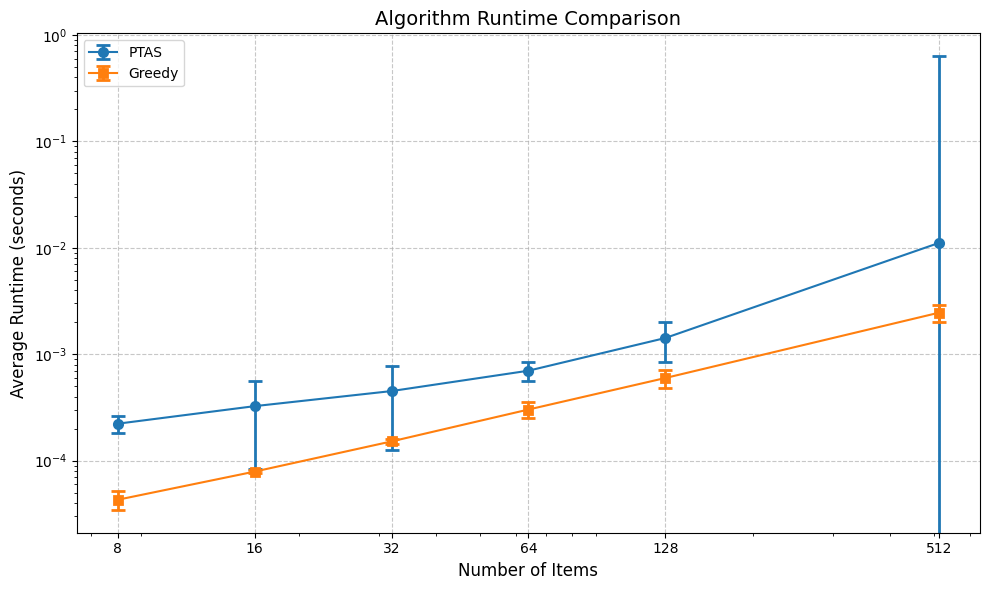

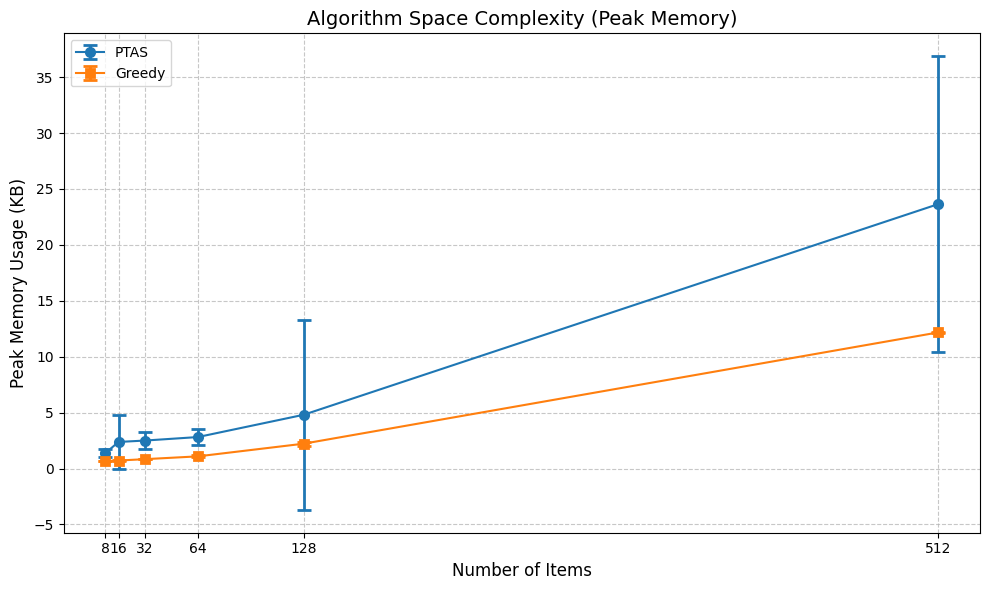

In [38]:
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import random
import tracemalloc
random.seed(6249)

def measure_performance():
    sizes = [8, 16, 32, 64, 128, 512]
    runs_per_size = 15
    epsilon = 0.9

    avg_times_ptas, std_devs_ptas = [], []
    avg_times_greedy, std_devs_greedy = [], []

    avg_mem_ptas, std_mem_ptas = [], []
    avg_mem_greedy, std_mem_greedy = [], []

    for size in sizes:
        run_times_ptas, run_times_greedy = [], []
        mem_usages_ptas, mem_usages_greedy = [], []

        print(f"Testing size {size}...")

        for _ in range(runs_per_size):
            items = generate_test_case(size)

            # PTAS timing + memory
            solver = PTAS(items, epsilon)
            tracemalloc.start()
            start = time.time()
            solver.solve()
            end = time.time()
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            run_times_ptas.append(end - start)
            mem_usages_ptas.append(peak / 1024)  # Convert to KB

            # Greedy timing + memory
            tracemalloc.start()
            start = time.time()
            greedy_2skp_height(items)
            end = time.time()
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            run_times_greedy.append(end - start)
            mem_usages_greedy.append(peak / 1024)

        # Aggregate stats
        avg_times_ptas.append(np.median(run_times_ptas))
        std_devs_ptas.append(np.std(run_times_ptas))
        avg_times_greedy.append(np.median(run_times_greedy))
        std_devs_greedy.append(np.std(run_times_greedy))

        avg_mem_ptas.append(np.median(mem_usages_ptas))
        std_mem_ptas.append(np.std(mem_usages_ptas))
        avg_mem_greedy.append(np.median(mem_usages_greedy))
        std_mem_greedy.append(np.std(mem_usages_greedy))

    # ---------- PLOT RUNTIME ----------
    plt.figure(figsize=(10, 6))
    plt.errorbar(sizes, avg_times_ptas, yerr=std_devs_ptas, fmt='-o', label='PTAS',
                 capsize=5, elinewidth=2, markeredgewidth=2)
    plt.errorbar(sizes, avg_times_greedy, yerr=std_devs_greedy, fmt='-s', label='Greedy',
                 capsize=5, elinewidth=2, markeredgewidth=2)
    plt.xlabel('Number of Items', fontsize=12)
    plt.ylabel('Average Runtime (seconds)', fontsize=12)
    plt.title('Algorithm Runtime Comparison', fontsize=14)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(sizes, labels=[str(s) for s in sizes])
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- PLOT MEMORY ----------
    plt.figure(figsize=(10, 6))
    plt.errorbar(sizes, avg_mem_ptas, yerr=std_mem_ptas, fmt='-o', label='PTAS',
                 capsize=5, elinewidth=2, markeredgewidth=2)
    plt.errorbar(sizes, avg_mem_greedy, yerr=std_mem_greedy, fmt='-s', label='Greedy',
                 capsize=5, elinewidth=2, markeredgewidth=2)
    plt.xlabel('Number of Items', fontsize=12)
    plt.ylabel('Peak Memory Usage (KB)', fontsize=12)
    plt.title('Algorithm Space Complexity (Peak Memory)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(sizes, labels=[str(s) for s in sizes])
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the performance measurement
measure_performance()

In [10]:
from typing import List, Tuple
from functools import lru_cache
import itertools

def exact_2d_shelf_knapsack(items: List[Tuple[float, float]]) -> float:
    """
    Exact shelf-based 2D knapsack using exhaustive search with memoization.

    Args:
        items: List of (width, height). Area = value.

    Returns:
        Max packed area (profit).
    """

    n = len(items)

    @lru_cache(maxsize=None)
    def dfs(remaining: Tuple[int], shelves: Tuple[Tuple[float, float], ...], used_height: float) -> float:
        best = 0.0

        for i in range(n):
            if i not in remaining:
                continue
            w, h = items[i]
            area = w * h

            # Try placing in existing shelf
            for si, (shelf_h, remaining_w) in enumerate(shelves):
                if h <= shelf_h and w <= remaining_w:
                    new_shelves = list(shelves)
                    new_shelves[si] = (shelf_h, remaining_w - w)
                    new_remaining = tuple(j for j in remaining if j != i)
                    best = max(best, area + dfs(new_remaining, tuple(new_shelves), used_height))

            # Try creating a new shelf
            if used_height + h <= 1.0 and w <= 1.0:
                new_shelves = shelves + ((h, 1.0 - w),)
                new_remaining = tuple(j for j in remaining if j != i)
                best = max(best, area + dfs(new_remaining, tuple(new_shelves), used_height + h))

        return best

    # Start with all items available and no shelves
    return dfs(tuple(range(n)), tuple(), 0.0)

Running size 2...
Running size 4...
Running size 6...
Running size 8...
Running size 10...
Running size 12...


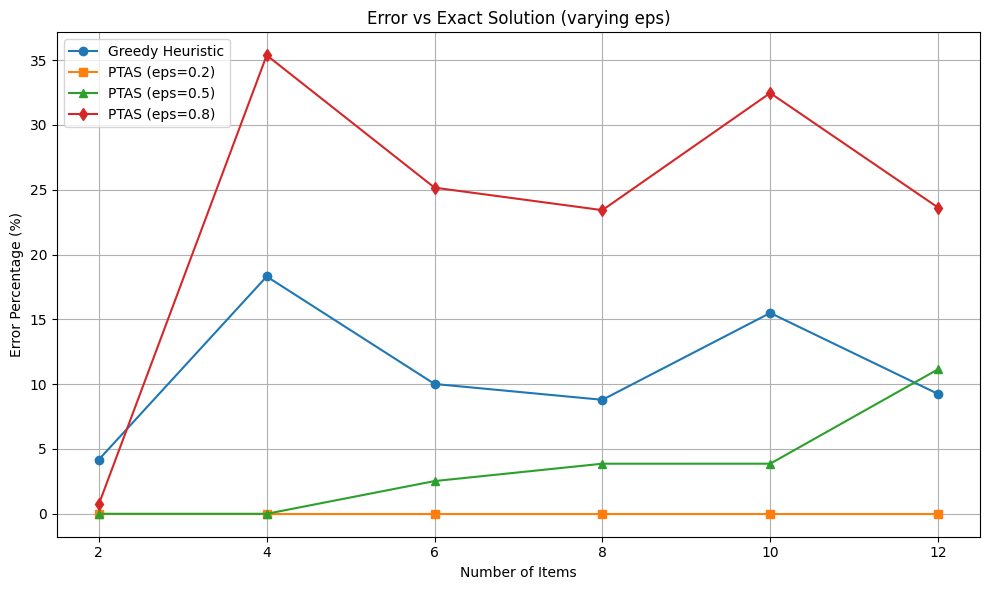

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_error_vs_exact(sizes, runs_per_size=10, epsilons=(0.2, 0.5, 0.8)):
    errors_greedy = []
    # Prepare a list for each epsilon
    errors_ptas = {eps: [] for eps in epsilons}

    for size in sizes:
        print(f"Running size {size}...")
        greedy_runs = []
        ptas_runs = {eps: [] for eps in epsilons}

        for _ in range(runs_per_size):
            items = generate_test_case(size)  # your test case generator

            opt = exact_2d_shelf_knapsack(items)
            if opt == 0:
                continue  # skip degenerate

            # Greedy baseline
            greedy_val = greedy_2skp_height(items)
            greedy_runs.append(abs(opt - greedy_val) / opt * 100)

            # PTAS for each eps
            for eps in epsilons:
                ptas_solver = PTAS(items, eps)
                approx_val = ptas_solver.solve()
                err = abs(opt - approx_val) / opt * 100
                ptas_runs[eps].append(err)

        # Record mean errors
        errors_greedy.append(np.mean(greedy_runs))
        for eps in epsilons:
            errors_ptas[eps].append(np.mean(ptas_runs[eps]))

    # Plotting
    plt.figure(figsize=(10,6))
    plt.plot(sizes, errors_greedy, 'o-', label='Greedy Heuristic')

    markers = ['s-', '^-', 'd-']
    for (eps, marker) in zip(epsilons, markers):
        plt.plot(sizes, errors_ptas[eps], marker, label=f'PTAS (eps={eps})')

    plt.xlabel('Number of Items')
    plt.ylabel('Error Percentage (%)')
    plt.title('Error vs Exact Solution (varying eps)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
sizes = [2, 4, 6, 8, 10, 12]
plot_error_vs_exact(sizes)
